## Recurrent Neural Network

This chapter presents various neural network models for financial time series analysis and provides examples of how they relate to well-known techniques in financial econometrics. Recurrent Neural Networks are presented as nonlinear time series models that generalize classical linear time series models like $\text{AR}(p)$. They provide a powerful approach for financial time series forecasting, generalize to non-stationary data, and have unique parameters over time.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [3]:
returns = data['Close'].pct_change(1).dropna()

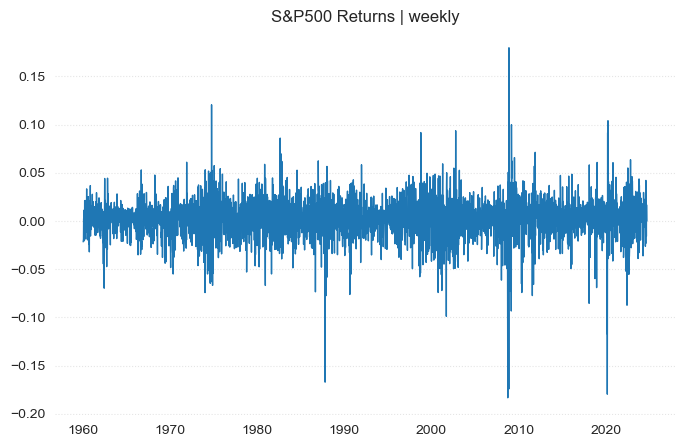

In [4]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    returns,
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('S&P500 Returns | weekly')
plt.show()

When data $\mathcal{D} = \{x_t, y_t\}_{t=1}^N$ consists of autocorrelated observations of $X$ and $Y$ at time points $t=1, \dots, N$, the prediction problem can be formulated as a sequence prediction problem. That is, the problem of building a nonlinear predictor $\hat{y}_{t+h}$ for the response $y_{t+h}$ using a high-dimensional input matrix $X_t$ composed of partial sequences of length $T$.

$$\hat{y}_{t+h} = f(X_t) \text{ where } X_t := \text{seq}_{T,t}(X) = \left(x_{t-T+1}, \dots, x_t\right)$$

Meanwhile, the Vanilla RNN model can be written as:

$$
\begin{align*}
h_t &= \sigma(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh}) \\
y_t &= W_{ho} h_t + b_o
\end{align*}
$$

Let's consider a special form of RNN model here. Consider a simple RNN case with 1 hidden layer ($H = 1$), no activation function, and input vector dimension $P = 1$. Additionally, assume $W_{z}^{(1)} = \phi_z, \vert \phi_z \vert < 1, W_x^{(1)} = \phi_x, W_y = 1, b_h = 0, b_y = \mu$. Then we can show that $f_{W^{(1)}, b^{(1)}}^{(1)}(X_t)$ is a $p$-th order autoregressive $\text{AR}(p)$ model with exponentially decaying autoregressive coefficients, i.e., $\phi_i = \phi_x \phi_z^{i-1}$.

$$
\begin{align*}
z_{t-p} &= \phi_x x_{t-p} \\
z_{t-T+2} &= \phi_z z_{t-T+1} + \phi_x x_{t-T+2} \\
\dots &= \dots \\
z_{t-1} &= \phi_z z_{t-2} + \phi_x x_{t-1} \\
\hat{x}_t &= z_{t-1}+\mu \\
\end{align*}
$$

Under these conditions, the following holds:

$$
\begin{align*}
\hat{x}_t &= \mu + \phi_x \left( L + \phi_z L^2 + \cdots + \phi_z^{p-1}L^p\right) \\
 &= \mu + \sum_{i=1} \phi_i x_{t-i}
\end{align*}
$$

This special case of autoregressive model $\hat{x}_t$ is stable, and its order can be identified through autocorrelation coefficient tests such as Durbin-Watson, Ljung-Box, and Box-Pierce tests. If we change the structure so that the recurrent weights $W_{z,i}^{(1)} = \phi_{z,i}$ are lag-dependent, the non-activated Hidden Layer becomes:

$$z_{t-i} = \phi_{z,i} z_{t-i-1} + \phi_x x_{t-i}$$

From this, we derive:

$$\hat{x}_t = \mu + \phi_x \left( L + \phi_{z,1}L^2 + \cdots + \prod_{i=1}^{p-1} \phi_{z,i}L^p\right)\left[x_t\right]$$

Therefore, the weights of this $\text{AR}(p)$ model are $\phi_j = \phi_x \prod_{i=1}^{j-1} \phi_{z,i}$, which can express a more flexible autocorrelation structure than the basic RNN case where weights decay exponentially. A linear RNN with an infinite number of time lags and no bias corresponds to exponential smoothing technique. That is, it corresponds to $z_t = \alpha x_t + (1 - \alpha)z_{t-1}$ when $W_z = 1 - \alpha, W_x = \alpha, W_y = 1$. Generalizing the linear RNN from $\text{AR}(p)$ to $\text{VAR}(p)$ is very straightforward and can be expressed as:

$$\hat{x}_t = \boldsymbol{\mu} + \sum_{j=1}^p \phi_j x_{t-j}$$ 

$$\phi_j := W^{(2)}\left( W_z^{(1)}\right)^{j-1} W_x^{(1)}$$

$$\boldsymbol{\mu} := W^{(2)}\sum_{j=1}^{p} \left( W_z^{(1)}\right)^{j-1} b^{(1)} + b^{(2)}$$

### 1. RNN Memory : Partial Auto Covariance

Generally, describing RNNs with nonlinear activation functions using classical models is more challenging. However, PACF provides additional insights here. First, let's consider the $\text{RNN}(1)$ process. The PACF with time lag 1 is as follows:

$$\tilde{\gamma}_1 = \mathbb{E} \left[ 
y_t - \mu, y_{t-1} - \mu
\right] = \mathbb{E} \left[ 
\hat{y}_t + \epsilon_t - \mu, y_{t-1} - \mu
\right]$$

For simplification, using an $\text{RNN}(1)$ model with a single recurrent weight $\phi$, we have:

$$\hat{y}_t = \sigma \left( \phi y_{t-1}\right)$$

From this equation, we can derive:

$$\tilde{\gamma}_1 = \mathbb{E} \left[ 
\sigma(\phi y_{t-1}) + \epsilon_t - \mu, y_{t-1} - \mu
\right] = \mathbb{E} \left[ y_{t-1} \sigma(\phi y_{t-1})\right]$$

Here, we assume $\mu = 0$ in the second part of the expression. If we set $\sigma := Id$, we can recover the $\text{AR}(1)$ covariance as:

$$\tilde{\gamma}_1 = \phi \mathbb{E}[y_{t-1}^2] = \phi \mathbb{V} [y_{t-1}]$$

Continuing with lag-2 Auto Covariance, we obtain:

$$\tilde{\gamma}_2 = \mathbb{E}\left[
y_t - P(y_t | y_{t-1}), y_{t-2} - P(y_{t-2} | y_{t-1}) 
\right]$$

And $P(y_t | y_{t-1})$ is approximated by $\text{RNN}(1)$ as:

$$\hat{y}_t = \sigma(\phi y_{t-1})$$

Substituting $y_t = \hat{y}_t + \epsilon_t$ into the above equation gives:

$$\tilde{\gamma}_2 = \mathbb{E} \left[
\epsilon_t, y_{t-2} - P(y_{t-2} | y_{t-1})
\right]$$

We can approximate $P(y_{t-2} | y_{t-1})$ with a backward $\text{RNN}(1)$ as:

$$\hat{y}_{t-2} = \sigma \left( \phi(\hat{y}_{t-1} + \epsilon_{t-1})\right)$$

From this equation, we can see that $\hat{y}_{t-2}$ depends on $\epsilon_{t-1}$ but not on $\epsilon_t$. Therefore, $y_{t-2} - P(y_{t-2} | y_{t-1})$ depends on $\left\{ \epsilon_{t-1}, \epsilon_{t-2}, \dots \right\}$. Consequently, we obtain $\tilde{\gamma}_2 = 0$.

On the other hand, consider the lag-2 Partial Auto Covariance of the $\text{RNN}(2)$ Process:

$$\hat{y}_{t-2} = \sigma \left( \phi \sigma (\phi(\hat{y}_t + \epsilon_t) + \epsilon_{t-1})\right)$$

This depends on $\epsilon_t$, and therefore the lag-2 Partial Auto Covariance is not zero. The Partial Auto Correlation $\tilde{\tau}_s = 0, s>p$, and consequently, the Partial Auto Correlation Function (PACF) for $\text{RNN}(p)$ cuts off at lag $p$, similar to the $\text{AR}(p)$ Process. Here, we assume PACF is independent of time. This property means that the estimated PACF can be used to identify the order of the $\text{RNN}$ model.

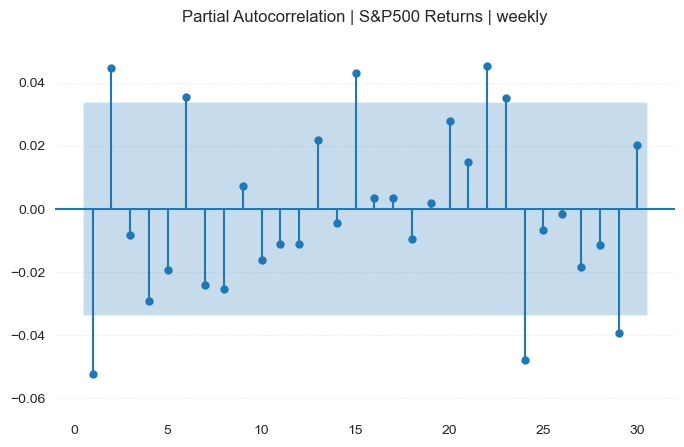

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(returns, ax = ax, lags = range(1, 31),  auto_ylims = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Autocorrelation | S&P500 Returns | weekly')
plt.show()

### 2. Stability

The stability constraints for the $\text{AR}(p)$ model presented later are generalized to $\text{RNN}$ by considering the following $\text{RNN}(1)$ model:

$$y_t = \Phi^{-1}(L)[\epsilon_t] = (1 - \sigma(W_z L + b))^{-1}[\epsilon_t]$$

Here, without loss of generality, we set $W_y = 1$ and $b_y = 0$, and remove superscripts for notational convenience. Expressing this as an infinite-dimensional nonlinear moving average model yields:

$$y_t = \frac{1}{1 - \sigma(W_z L + b)}[\epsilon_t] = \sum_{j=0}^\infty \sigma^j (W_z L + b)[\epsilon_t]$$

### 3. Stationarity

The linear univariate $\text{RNN}(p)$ considered above has the following companion matrix:

$$C := \begin{pmatrix} 
0 & 1 & 0 & \cdots & 0 \\ 
0 & 0 & 1 & 0 & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 1 \\
\phi^{-p} & -\phi^{-p+1} & \cdots & -\phi^{-2} & -\phi^{-1}
\end{pmatrix}$$

When $\phi \neq 0$, the model exhibits non-stationarity. Since this is the case for linear $\text{RNN}$, we can exclude the choice of linear activation functions. Therefore, it appears that some nonlinear activation function is needed for the model to achieve stationarity. However, we cannot prove stationarity using Cayley-Hamilton.

#### Half Life

Assume the output of $\text{RNN}$ is in $\mathbb{R}^d$. The half-life of lag is the smallest number $k$ that satisfies the following for the normalized $j$-th output in the function composition of $\tilde{\sigma}(x) := \sigma(W_z x + b)$:


$$
r_j^{(k)} = \frac{
\left( W_y \tilde{\sigma}\circ_1 \tilde{\sigma}\circ_2 \cdots \circ_{k-1} \tilde{\sigma}(\boldsymbol{1}) + b_y\right)_j
}{
\left( W_y \tilde{\sigma}(\boldsymbol{1}) + b_y\right)_j
} \leq 0.5, \quad k \geq 2, \quad \forall j \in \{1, \dots, d\}
$$

Since the output is normalized, the unit impulse response function of lag-1 guarantees that the ratio $r_j^{(1)} = 1$ for each $j$. This modified definition exists to explain the effects of the activation function and the quasi-affine transformation that does not exist in the $\text{AR}(p)$ model. In general, there is no guarantee that the half-life is finite, but we can find parameter values that can discover the half-life. For example, for simplicity, assume that a univariate $\text{RNN}$ is given by $\hat{x}_t = z_{t-1}$ and:

$$z_t = \sigma(z_{t-1} + x_t)$$

Then the lag-1 shock is $\hat{x}_t = \tilde{\sigma}(\boldsymbol{1}) = \sigma(0 + 1)$, and the lag-2 shock is calculated as $\hat{x}_t = \sigma(\sigma(1) + 1) = \tilde{\sigma} \circ \tilde{\sigma}(1)$.

In [40]:
import torch.nn as nn
import torch.optim as optim

class RecurrentNeuralNetwork(nn.Module):
    def __init__(
            self, 
            input_size : int, 
            hidden_size : int, 
            output_size : int, 
            num_layers : int = 2 
        ) -> None :
        super(RecurrentNeuralNetwork, self).__init__()
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size, 
            output_size
        )
        
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [41]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [42]:
X.head()

,t-1,t-2
Date,,
1960-01-22,-0.020377,-0.021612
1960-01-29,-0.018878,-0.020377
1960-02-05,0.002494,-0.018878
1960-02-12,-0.019371,0.002494
1960-02-19,0.011236,-0.019371


In [43]:
y.head()

Date
1960-01-22   -0.018878
1960-01-29    0.002494
1960-02-05   -0.019371
1960-02-12    0.011236
1960-02-19    0.002330
Name: returns, dtype: float64

In [44]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

In [45]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.001
num_epochs = 1
batch_size = 2

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [46]:
rnn = RecurrentNeuralNetwork(
    input_size, 
    hidden_size, 
    output_size,
    num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    rnn.parameters(), 
    lr = learning_rate
)

In [47]:
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [48]:
for epoch in range(num_epochs):
    rnn.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = rnn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 0.008454


In [49]:
rnn.eval()
with torch.no_grad():
    predicted_full = rnn(X_test_tensor)
    predicted_full = predicted_full.squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

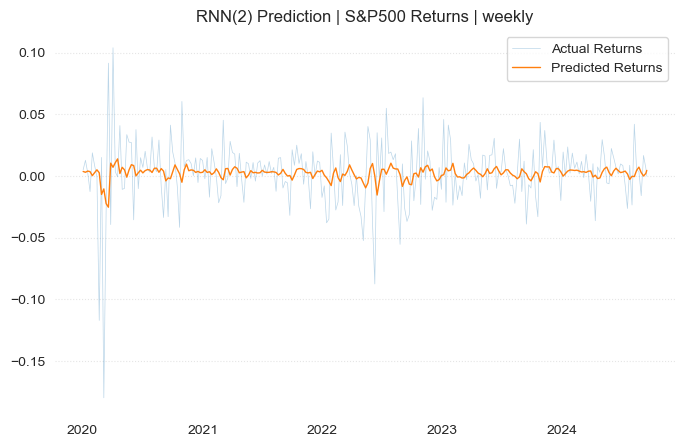

In [50]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5, alpha = 0.3)
plt.plot(y_test.index, predicted_full, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

### 4. Generalized Recurrent Neural Network

The classical RNN discussed earlier treats errors as homoskedastic, meaning the errors are i.i.d. We briefly mention that by modifying the loss function to the Mahalanobis length of the residual vector squared, the RNN can be generalized to a heteroskedastic model. This approach is called Generalized Recurrent Neural Network. Here, we note that the field of Machine Learning in econometrics is in its early stages and incomplete, and while these methodologies are theoretically appealing, they have not yet been empirically proven.

In its simplest form, we solve the weighted least squares minimization problem using data $\mathcal{D}_t$:

$$
\begin{align*}
\min_{W,b} ~ & ~ f(W, b) + \lambda \phi(W,b) \\
\mathcal{L}_{\Sigma} (Y, \hat{Y}) & := (Y - \hat{Y})^T \Sigma^{-1} (Y - \hat{Y}) \\
\Sigma_{tt} &= \sigma_t^2 \\
\Sigma_{tt^\prime} &= \rho_{tt^\prime} \sigma_t \sigma_t^\prime \\
f(W,b) &= \frac{1}{T} \sum_{t=1}^T \mathcal{L}_{\Sigma}(y_t, \hat{y}_t)
\end{align*}
$$

Here, $\Sigma := \mathbb{E} \left[ \epsilon \epsilon^T | \mathcal{X}_t \right]$ is the conditional covariance matrix of residual errors, and $\phi(W,b)$ is the regularization penalty term. The conditional covariance matrix must be estimated. This is done using the notation $()^T$ for vector transpose and $()^\prime$ for model parameters fitted under heteroskedastic errors as follows: First, for each $t = 1, 2, \dots, T$, we find weights $\hat{W}_t$ and bias $\hat{b}_t$ using the standard loss function to estimate the residual error $\boldsymbol{\epsilon}_t \in \mathbb{R}^N$ on the training set. The error is:

$$\boldsymbol{\epsilon}_t = \boldsymbol{y}_t - F_{\hat{W}_t, \hat{b}_t}(\mathcal{X}_t)$$

The Sample Conditional Covariance Matrix $\hat{\Sigma}$ is estimated as:

$$\hat{\Sigma} = \frac{1}{T - 1}\sum_{i=1}^T \boldsymbol{\epsilon}_t \boldsymbol{\epsilon}_t ^T$$

We estimate the fitted heteroskedastic neural network model by solving the weighted least squares minimization problem. The more refined error at this stage is:

$$\boldsymbol{\epsilon}_t^\prime = \boldsymbol{y}_t - F_{\hat{W}_t^\prime, \hat{b}_t^\prime} (\mathcal{X}_t)$$

The fitted GRNN $F_{\hat{W}_t^\prime, \hat{b}_t^\prime}$ can then be used for prediction without further modification. The effect of the Sample Covariance Matrix is to adjust the importance of observations in the training set based on the variance and correlation of errors. This approach can be thought of as similar to how the GARCH model extends the AR model, but applied to RNN. Of course, the GARCH model deals with error distributions parametrically and estimates recursive relationships to predict conditional volatility. In contrast, GRNN relies on empirical error distributions and does not predict conditional volatility. However, using time series cross-validation, a separate regression is performed across the diagonal of the empirical conditional volatility $\Sigma$.

In [51]:
class GRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_prev):
        h_next = self.rnn_cell(x, h_prev)
        output = self.fc(h_next)
        return output, h_next

class GRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([GRNNCell(input_size if i == 0 else hidden_size, hidden_size, output_size) for i in range(num_layers)])
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            for i, cell in enumerate(self.cells):
                output, h[i] = cell(x_t, h[i])
                x_t = output  # Pass the output to the next layer if there are multiple layers
            outputs.append(output.unsqueeze(1))
        
        return torch.cat(outputs, dim=1)

In [52]:
grnn = GRNN(
    input_size, 
    hidden_size, 
    output_size,
    num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    grnn.parameters(), 
    lr = learning_rate
)

In [53]:
num_epochs = 1
for epoch in range(num_epochs):
    grnn.train()
    optimizer.zero_grad()

    outputs = grnn(X_train_tensor)

    outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.068643


In [54]:
grnn.eval()
with torch.no_grad():
    predicted_grnn = grnn(X_test_tensor)
    predicted_grnn = predicted_grnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

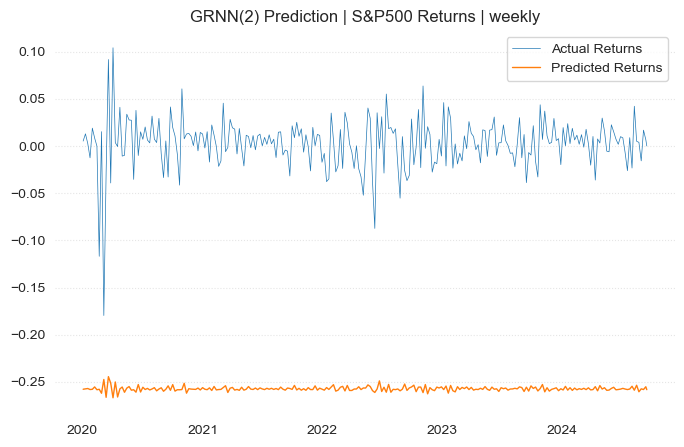

In [55]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_grnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'GRNN(2) Prediction | S&P500 Returns | weekly')
plt.show()